In [1]:
"""
Notebook Matrix Profile – ampiimts Python 3.11 package

Goal:
From pre processing signal with original value, normalize value, timestamp. 
We identify discord and motifs with a fix window on matrix profile methode (stumpy)
"""
%matplotlib widget
import pandas as pd
import ampiimts
import os

In [2]:
folder = '../../dataset'
pds = []

with os.scandir(folder) as entries:
    for entry in entries:
        if entry.is_file() and entry.name.endswith('csv'):
            # list of sensors with some parameters -> list[pd.DataFrame[timestamp, value1, value2, etc..., latitude, longitude]]) 
            pds.append((pd.read_csv(folder+'/'+entry.name), entry.name))
pds = pds[:1]

nyc_taxi.csv
[WINDOW] Fenêtre utilisateur → 24h


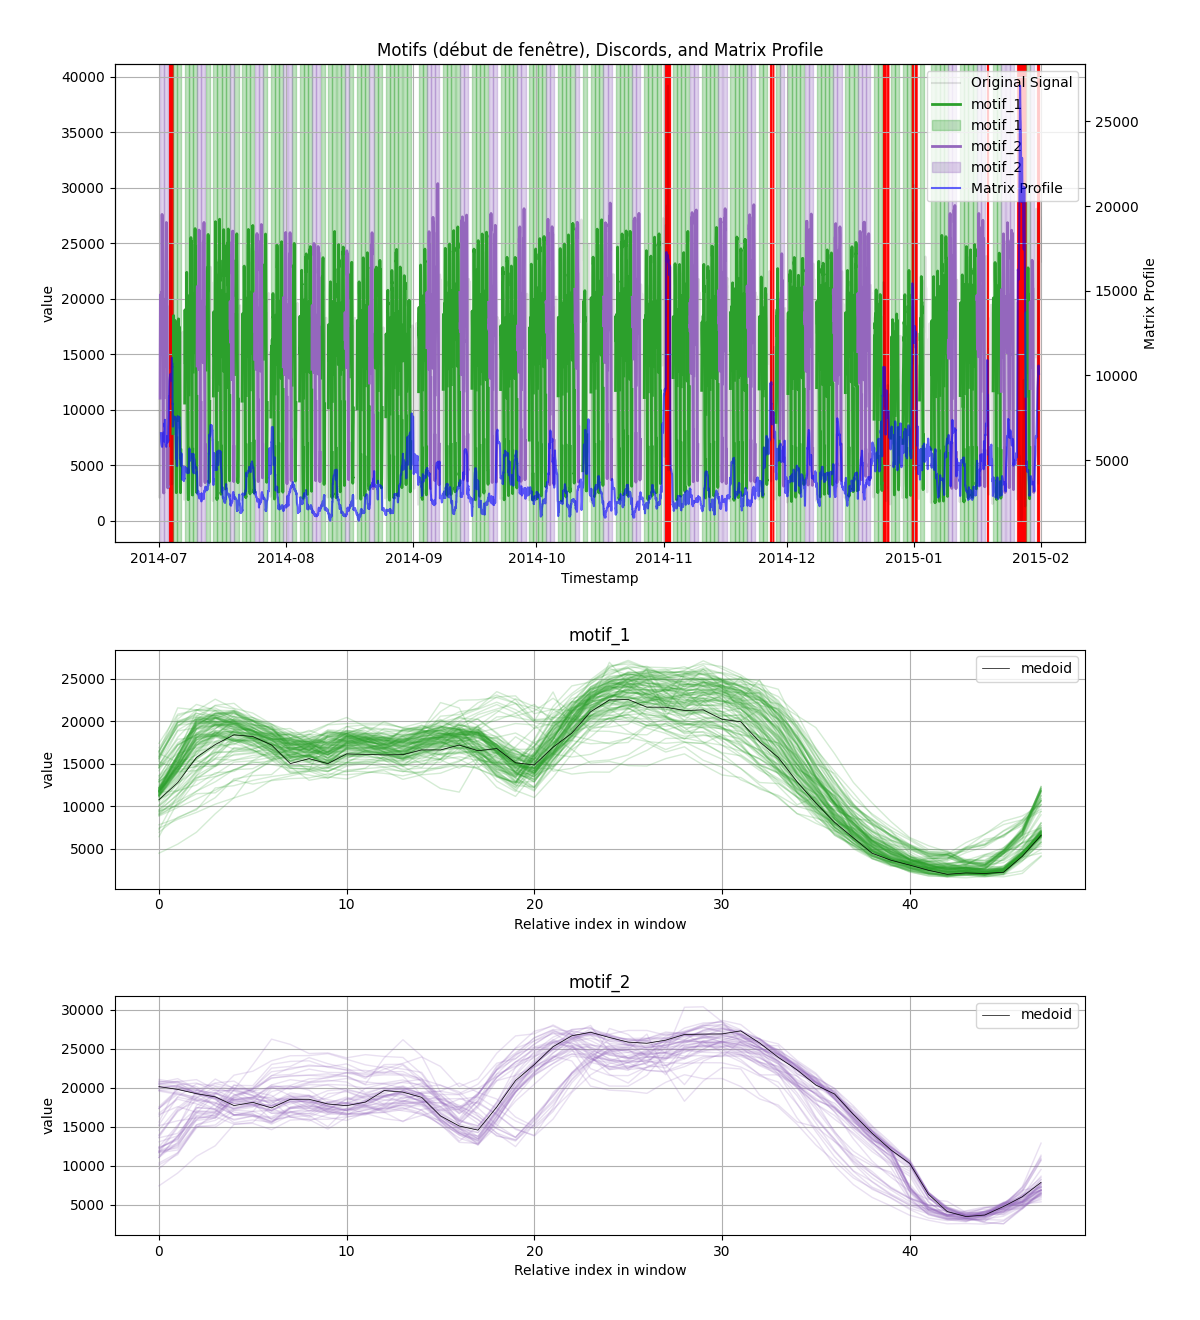

In [4]:
# get original dataframe
for df, name in pds:
    print(name)
    df_normalize = ampiimts.pre_processed(df, window_size='24h')
    result = ampiimts.matrix_profile(df_normalize, max_matches=50, max_motifs=3)
    ampiimts.plot_patterns_and_discords(ampiimts.interpolate(df), result)